##### 氣象機器人 (2) - 目前氣象資訊
延續「氣象機器人 (1) - 雷達回波與地震資訊」文章，這篇教學會讓 LINE 氣象機器人串接目前氣象資訊，只要使用 LINE 預設的功能提供地址，\
就能回傳該地址的即時天氣資訊。

##### 取得某個地點的氣象資訊 
前往中央氣象局開放資料，從氣象資料開放平臺裡，找到「自動氣象站-氣象觀測資料」和「局屬氣象站-現在天氣觀測報告」兩個資料集，接著執行下方程式碼，\
就可以看見某個地址的天氣狀況。

資料連結：
* [自動氣象站-氣象觀測資料](https://opendata.cwa.gov.tw/dataset/observation/O-A0001-001)
* [局屬氣象站-現在天氣觀測報告](https://opendata.cwa.gov.tw/dataset/observation/O-A0003-001)

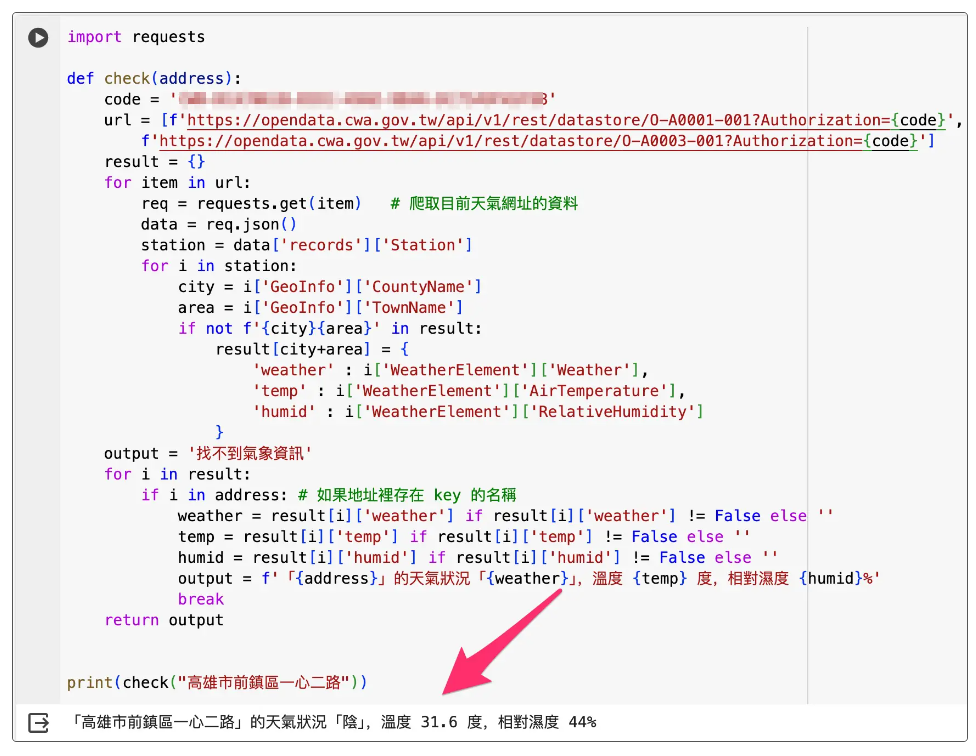

In [ ]:
import requests

def check(address):
    code = '你的氣象 token'
    url = [f'https://opendata.cwa.gov.tw/api/v1/rest/datastore/O-A0001-001?Authorization={code}',
        f'https://opendata.cwa.gov.tw/api/v1/rest/datastore/O-A0003-001?Authorization={code}']
    result = {}
    for item in url:
        req = requests.get(item)   # 爬取目前天氣網址的資料
        data = req.json()
        station = data['records']['Station']
        for i in station:
            city = i['GeoInfo']['CountyName']
            area = i['GeoInfo']['TownName']
            if not f'{city}{area}' in result:
                result[city+area] = {
                    'weather' : i['WeatherElement']['Weather'],
                    'temp' : i['WeatherElement']['AirTemperature'],
                    'humid' : i['WeatherElement']['RelativeHumidity']
                }
    output = '找不到氣象資訊'
    for i in result:
        if i in address: # 如果地址裡存在 key 的名稱
            weather = result[i]['weather'] if result[i]['weather'] != False else ''
            temp = result[i]['temp'] if result[i]['temp'] != False else ''
            humid = result[i]['humid'] if result[i]['humid'] != False else ''
            output = f'「{address}」的天氣狀況「{weather}」，溫度 {temp} 度，相對濕度 {humid}%'
            break
    return output


print(check("屏東縣滿州鄉一心二路"))

##### 透過 LINE BOT 詢問天氣 
延伸「氣象機器人 (1) - 雷達回波與地震資訊」的程式，額外加入 weather 函式，當判斷 type 為 location 時，透過 weather 函式抓取該位置的氣象資料。

In [ ]:
from flask import Flask, request
from pyngrok import ngrok   # Colab 環境需要，本機環境不需要
import json, time, requests

# 載入 LINE Message API 相關函式庫
from linebot import LineBotApi, WebhookHandler
from linebot.exceptions import InvalidSignatureError
from linebot.models import MessageEvent, TextMessage, TextSendMessage, StickerSendMessage, ImageSendMessage, LocationSendMessage

app = Flask(__name__)

# Colab 環境需要下面這三行，本機環境不需要
port = "5000"
public_url = ngrok.connect(port).public_url
print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\" ")

def earth_quake():
    result = []
    code = '你的 token'
    try:
        # 小區域 https://opendata.cwa.gov.tw/dataset/earthquake/E-A0016-001
        url = f'https://opendata.cwa.gov.tw/api/v1/rest/datastore/E-A0016-001?Authorization={code}'
        req1 = requests.get(url)  # 爬取資料
        data1 = req1.json()       # 轉換成 json
        eq1 = data1['records']['Earthquake'][0]           # 取得第一筆地震資訊
        t1 = data1['records']['Earthquake'][0]['EarthquakeInfo']['OriginTime']
        # 顯著有感 https://opendata.cwa.gov.tw/dataset/all/E-A0015-001
        url2 = f'https://opendata.cwa.gov.tw/api/v1/rest/datastore/E-A0015-001?Authorization={code}'
        req2 = requests.get(url2)  # 爬取資料
        data2 = req2.json()        # 轉換成 json
        eq2 = data2['records']['Earthquake'][0]           # 取得第一筆地震資訊
        t2 = data2['records']['Earthquake'][0]['EarthquakeInfo']['OriginTime']
        
        result = [eq1['ReportContent'], eq1['ReportImageURI']] # 先使用小區域地震
        if t2>t1:
          result = [eq2['ReportContent'], eq2['ReportImageURI']] # 如果顯著有感地震時間較近，就用顯著有感地震
    except Exception as e:
        print(e)
        result = ['抓取失敗...','']
    return result

def weather(address):
    try:
        code = '你的氣象 token'
        url = [f'https://opendata.cwa.gov.tw/api/v1/rest/datastore/O-A0001-001?Authorization={code}',
            f'https://opendata.cwa.gov.tw/api/v1/rest/datastore/O-A0003-001?Authorization={code}']
        result = {}
        for item in url:
            req = requests.get(item)   # 爬取目前天氣網址的資料
            data = req.json()
            station = data['records']['Station']   # 觀測站
            for i in station:
                city = i['GeoInfo']['CountyName']  # 縣市
                area = i['GeoInfo']['TownName']    # 區域
                # 使用「縣市+區域」作為 key，例如「高雄市前鎮區」就是 key
                # 如果 result 裡沒有這個 key，就記錄相關資訊
                if not f'{city}{area}' in result:
                    weather = i['WeatherElement']['Weather']
                    temp = i['WeatherElement']['AirTemperature'] 
                    humid = i['WeatherElement']['RelativeHumidity']
                    # 回傳結果
                    result[f'{city}{area}'] = f'目前天氣狀況「{weather}」，溫度 {temp} 度，相對濕度 {humid}%！'

        output = '找不到氣象資訊'
        for i in result:
            if i in address: # 如果地址裡存在 key 的名稱
                output = f'「{address}」{result[i]}'
                break
    except Exception as e:
        print(e)
        output = '抓取失敗...'
    return output

access_token = '你的 Access Token'
channel_secret = '你的 Channel Secret'

@app.route("/", methods=['POST'])
def linebot():
    body = request.get_data(as_text=True)                    # 取得收到的訊息內容
    try:
        line_bot_api = LineBotApi(access_token)     # 確認 token 是否正確
        handler = WebhookHandler(channel_secret)    # 確認 secret 是否正確
        signature = request.headers['X-Line-Signature']             # 加入回傳的 headers
        handler.handle(body, signature)      # 綁定訊息回傳的相關資訊
        json_data = json.loads(body)         # 轉換內容為 json 格式
        reply_token = json_data['events'][0]['replyToken']    # 取得回傳訊息的 Token ( reply message 使用 )
        user_id = json_data['events'][0]['source']['userId']  # 取得使用者 ID ( push message 使用 )
        print(json_data)                                      # 印出內容
        type = json_data['events'][0]['message']['type']
        if type == 'text':
            text = json_data['events'][0]['message']['text']
            if text == '雷達回波圖' or text == '雷達回波':
                line_bot_api.push_message(user_id, TextSendMessage(text='馬上找給你！抓取資料中....'))
                img_url = f'https://cwaopendata.s3.ap-northeast-1.amazonaws.com/Observation/O-A0058-001.png?{time.time_ns()}'
                img_message = ImageSendMessage(original_content_url=img_url, preview_image_url=img_url)
                line_bot_api.reply_message(reply_token,img_message)
            elif text == '地震':
                line_bot_api.push_message(user_id, TextSendMessage(text='馬上找給你！抓取資料中....'))
                reply = earth_quake()
                text_message = TextSendMessage(text=reply[0])
                line_bot_api.reply_message(reply_token,text_message)
                line_bot_api.push_message(user_id, ImageSendMessage(original_content_url=reply[1], preview_image_url=reply[1]))
            else:          
                text_message = TextSendMessage(text=text)
                line_bot_api.reply_message(reply_token,text_message)
        elif type == 'location':
            line_bot_api.push_message(user_id, TextSendMessage(text='馬上找給你！抓取資料中....'))
            address = json_data['events'][0]['message']['address'].replace('台','臺')  # 取出地址資訊，並將「台」換成「臺」
            reply = weather(address)          
            text_message = TextSendMessage(text=reply)
            line_bot_api.reply_message(reply_token,text_message)
    except Exception as e:
        print(e)
    return 'OK'                 # 驗證 Webhook 使用，不能省略

if __name__ == "__main__":
    app.run()

完成後重新執行，設定新的 ngrok 網址為 Webhook，驗證成功後，LINE 裡面傳送地址資訊，LINE BOT 就會回傳這個地點的即時天氣資訊。

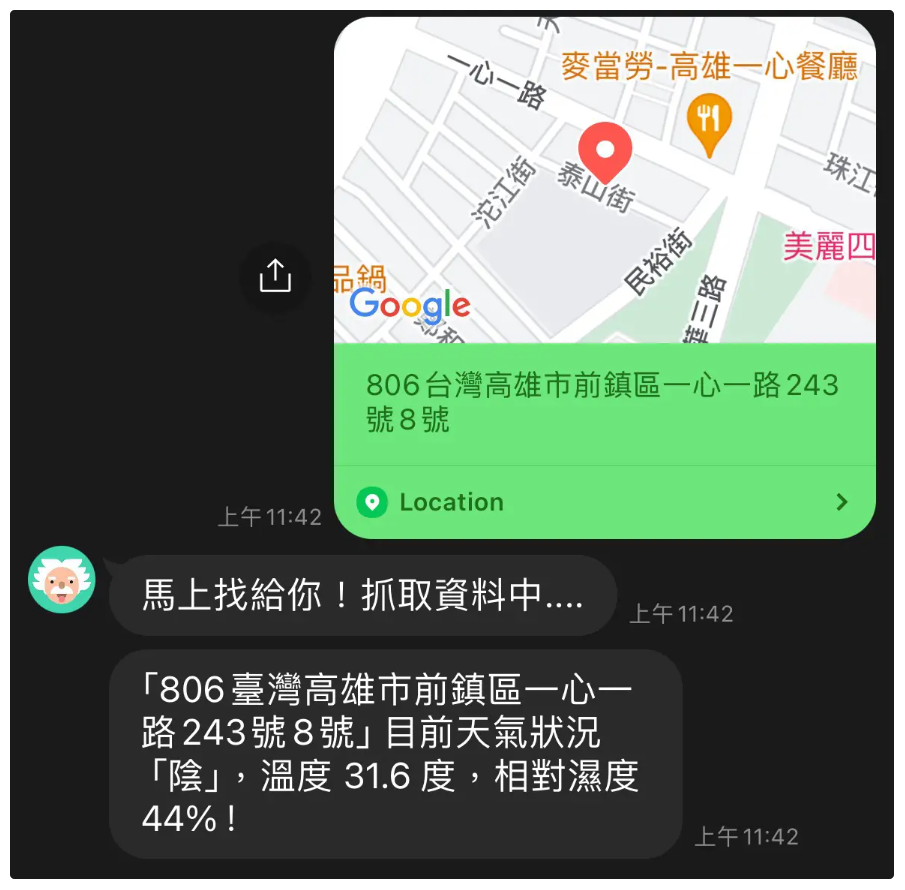

##### 小結 
目前的氣象機器人已經可以串接地震資訊、雷達回波和即時天氣狀況，接下來的幾篇會繼續介紹如何串接天氣預報和空氣品質資訊。